In [1]:
# Core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# For loading and transforming data
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Metrics
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

# Additional utilities
from torch.optim import Adam
from torch.nn import Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d
from torchvision.utils import save_image

In [2]:
import os
import shutil

# Base directory where the original folders are located
base_dir = '/kaggle/input/cv-project-detector/Classifier Data'

# New directory where the combined images will be located
new_base_dir = '/kaggle/working/images/'

# Create new directories if they don't exist
os.makedirs(os.path.join(new_base_dir, 'Diseased'), exist_ok=True)
os.makedirs(os.path.join(new_base_dir, 'No_Disease'), exist_ok=True)

# Categories and diseases
categories = ['train', 'val']
diseases = ['Disease_Present', 'No_Disease']

# Copy the files
for cat in categories:
    for disease in diseases:
        # Directory where the current images are located
        old_dir = os.path.join(base_dir, cat, disease)
        
        # Directory where the images are going to be moved to
        new_dir_name = 'Diseased' if disease == 'Disease_Present' else 'No_Disease'
        new_dir = os.path.join(new_base_dir, new_dir_name)

        # Copy each file
        for filename in os.listdir(old_dir):
            old_file = os.path.join(old_dir, filename)
            new_file = os.path.join(new_dir, filename)
            
            # Check if the file already exists, if so, skip or rename
            if not os.path.exists(new_file):
                shutil.copy(old_file, new_file)  # Copy the file
            else:
                # If a file with the same name exists, append an extra identifier before the extension
                base, extension = os.path.splitext(new_file)
                new_filename = base + '_duplicate' + extension
                shutil.copy(old_file, new_filename)


## CGAN 64 x 64

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_shape, n_classes):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            # Input is Z, going into a convolution
            nn.ConvTranspose2d(z_dim + n_classes, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # State size. (512) x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # State size. (256) x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # State size. (128) x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # State size. (64) x 32 x 32
            nn.ConvTranspose2d(64, img_shape[0], 4, 2, 1, bias=False),
            nn.Tanh()
            # Output size. (nc) x 64 x 64
        )

    def forward(self, noise, labels):
        # Concatenate label embedding and image to produce input
        gen_input = torch.cat((self.label_embedding(labels), noise), -1)
        gen_input = gen_input.view(gen_input.size(0), -1, 1, 1)
        img = self.model(gen_input)
        img = img.view(img.size(0), *self.img_shape)
        return img

class Discriminator(nn.Module):
    def __init__(self, img_shape, n_classes):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        self.img_shape = img_shape

        self.model = nn.Sequential(
            # Input is (nc) x 64 x 64
            nn.Conv2d(img_shape[0] + n_classes, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (64) x 32 x 32
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (128) x 16 x 16
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (256) x 8 x 8
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (512) x 4 x 4
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Expand label embedding to match image shape
        labels = self.label_embedding(labels)
        labels = labels.view(labels.size(0), labels.size(1), 1, 1)
        labels = labels.expand(-1, -1, img.size(2), img.size(3))
        
        # Concatenate label embedding and image to produce input
        d_input = torch.cat((img, labels), 1)  # Concatenate along the channel dimension
        
        validity = self.model(d_input)
        return validity.view(-1, 1)


In [ ]:
# Hyperparameters
import torch.optim as optim
z_dim = 100
img_size = 64
img_channels = 3  # or 3 for RGB images
n_classes = 2  # Diseased or not
lr = 0.0002
batch_size = 64
epochs = 200
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Initialize generator and discriminator
img_shape = (img_channels, img_size, img_size)
generator = Generator(z_dim=z_dim, img_shape=img_shape, n_classes=n_classes).to(device)
generator.label_embedding = generator.label_embedding.to(device)
discriminator = Discriminator(img_shape=img_shape, n_classes=n_classes).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [ ]:
# Image transformations
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Data loaders for your dataset
dataloader = DataLoader(
    datasets.ImageFolder('/kaggle/working/images/', transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

# Loss function
adversarial_loss = torch.nn.BCELoss()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision.utils import save_image, make_grid

# Function to display images
def show_generated(imgs, num_images=25):
    imgs = (imgs + 1) / 2  # Rescale images from [-1,1] to [0,1]
    grid = make_grid(imgs[:num_images], nrow=5).detach().cpu().numpy()
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show()

# Training Loop
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):

        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to(device)
        
        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        
        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = torch.randn(imgs.size(0), z_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Log Progress
        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Checkpoint images every 10 epochs
        if epoch % 10 == 0 and i == len(dataloader) - 1:  # Last batch of the epoch
            with torch.no_grad():
                # Generate a batch of images
                z = torch.randn(batch_size, z_dim).to(device)
                gen_labels = torch.randint(0, n_classes, (batch_size,)).to(device)
                gen_imgs = generator(z, gen_labels)
                
                # Display generated images
                show_generated(gen_imgs)


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image, make_grid
from PIL import Image
import os

# Function to display and save generated images
def show_and_save_generated(imgs, save_path, num_images=10, quality=95):
    imgs = (imgs + 1) / 2  # Rescale images from [-1,1] to [0,1]
    grid = make_grid(imgs[:num_images], nrow=5).detach().cpu().numpy()
    grid = np.transpose(grid, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

    # Convert numpy array to PIL image
    pil_image = Image.fromarray((grid * 255).astype(np.uint8))

    # Save PIL image with desired quality
    pil_image.save(save_path, quality=quality)

# Define a directory to save model checkpoints
checkpoint_dir = '/kaggle/working/checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a directory to save generated images
generated_images_dir = '/kaggle/working/generated_images/'
os.makedirs(generated_images_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Training Loop
for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        # Adversarial ground truths
        valid = torch.ones(imgs.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to(device)
        
        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = torch.randn(imgs.size(0), z_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        # Log Progress
        print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

    # Save model checkpoints every 10 epochs
    if epoch % 10 == 0:
        # Save generator and discriminator models
        torch.save(generator.state_dict(), f'{checkpoint_dir}generator_epoch_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'{checkpoint_dir}discriminator_epoch_{epoch}.pth')

        # Generate and save example images
        with torch.no_grad():
            z_example = torch.randn(10, z_dim).to(device)  # Generate 10 random noise vectors
            gen_labels_example = torch.randint(0, n_classes, (10,)).to(device)  # Generate random labels
            gen_imgs_example = generator(z_example, gen_labels_example)

            save_path = f'{generated_images_dir}generated_images_epoch_{epoch}.jpg'
            show_and_save_generated(gen_imgs_example, save_path, num_images=10, quality=95)  # Save only 10 images with high quality


### CGans - 256 by 256

In [3]:
import torch

class Generator(nn.Module):
    def __init__(self, z_dim, img_shape, n_classes):
        super(Generator, self).__init__()
        self.img_shape = img_shape
        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.ConvTranspose2d(z_dim + n_classes, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 4, 2, 1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 4, 2, 1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, self.img_shape[0], 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, z, labels):
        # Embed labels and concatenate with the noise vector
        label_emb = self.label_embedding(labels)  # Transform labels into embeddings
        label_emb = label_emb.unsqueeze(2).unsqueeze(3)  # Reshape to match the batch and noise dimensions
        z = z.unsqueeze(2).unsqueeze(3)  # Reshape z to match the batch and label dimensions
        # Concatenate noise vector z and label embeddings along the channel dimension
        input_gen = torch.cat([z, label_emb], dim=1)

        # Generate an image from the noise vector and labels
        output = self.model(input_gen)
        output = output.view(-1, *self.img_shape)  # Reshape to the output image size (C, H, W)

        return output


In [4]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, img_shape, n_classes):
        super(Discriminator, self).__init__()
        nc = img_shape[0]  # Number of channels in the images

        self.label_embedding = nn.Embedding(n_classes, n_classes)
        self.model = nn.Sequential(
            # input is (nc) x 256 x 256
            nn.Conv2d(nc + n_classes, 64, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (64) x 128 x 128
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (128) x 64 x 64
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (256) x 32 x 32
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (512) x 16 x 16
            nn.Conv2d(512, 1024, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (1024) x 8 x 8
            nn.Conv2d(1024, 2048, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2048),
            nn.LeakyReLU(0.2, inplace=True),
            # State size. (2048) x 4 x 4
            nn.Conv2d(2048, 1, 4, stride=1, padding=0, bias=False),
            nn.Flatten(),
            nn.Sigmoid()
            # Output size. 1
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        label_embedding = self.label_embedding(labels)
        label_embedding = label_embedding.view(label_embedding.size(0), label_embedding.size(1), 1, 1)
        label_embedding = label_embedding.repeat(1, 1, img.shape[2], img.shape[3])
        img = torch.cat((img, label_embedding), 1)

        return self.model(img)


In [6]:
# Hyperparameters
import torch.optim as optim
z_dim = 100
img_size = 256
img_channels = 3  # or 3 for RGB images
n_classes = 2  # Diseased or not
lr = 3e-4
batch_size = 64
epochs = 50
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# Initialize generator and discriminator
img_shape = (img_channels, img_size, img_size)
generator = Generator(z_dim=z_dim, img_shape=img_shape, n_classes=n_classes).to(device)
generator.label_embedding = generator.label_embedding.to(device)
discriminator = Discriminator(img_shape=img_shape, n_classes=n_classes).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))


In [7]:
# Image transformations
from torchvision import datasets, transforms
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Data loaders for your dataset
dataloader = DataLoader(
    datasets.ImageFolder('/kaggle/working/images/', transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

# Loss function
adversarial_loss = torch.nn.BCELoss()

In [8]:
# Accessing class names
class_names = dataloader.dataset.classes
print("Class Names:", class_names)

Class Names: ['Diseased', 'No_Disease']


[Epoch 0/50] [Batch 137/138] [D loss: 0.932580828666687] [G loss: 2.8409430980682373]


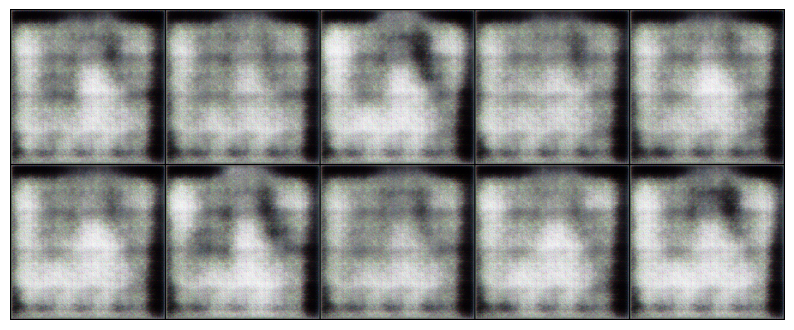

[Epoch 1/50] [Batch 137/138] [D loss: 0.6553309559822083] [G loss: 3.2009899616241455]
[Epoch 2/50] [Batch 137/138] [D loss: 0.8740714192390442] [G loss: 0.7160758972167969]
[Epoch 3/50] [Batch 137/138] [D loss: 0.8259393572807312] [G loss: 0.32102617621421814]
[Epoch 4/50] [Batch 137/138] [D loss: 1.0125086307525635] [G loss: 0.3682578206062317]
[Epoch 5/50] [Batch 137/138] [D loss: 0.48901665210723877] [G loss: 0.9110867381095886]
[Epoch 6/50] [Batch 137/138] [D loss: 0.4612710475921631] [G loss: 1.2549740076065063]
[Epoch 7/50] [Batch 137/138] [D loss: 0.4356558322906494] [G loss: 2.398200750350952]
[Epoch 8/50] [Batch 137/138] [D loss: 0.27052339911460876] [G loss: 2.00350022315979]
[Epoch 9/50] [Batch 137/138] [D loss: 0.24847735464572906] [G loss: 1.2008980512619019]
[Epoch 10/50] [Batch 137/138] [D loss: 0.42642807960510254] [G loss: 2.6347408294677734]


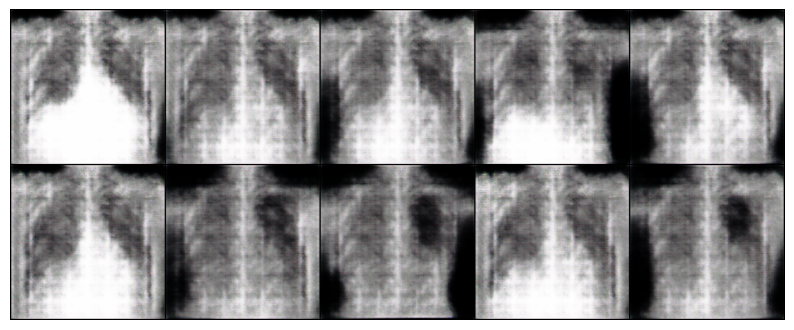

[Epoch 11/50] [Batch 137/138] [D loss: 0.4589999318122864] [G loss: 0.5961496233940125]
[Epoch 12/50] [Batch 137/138] [D loss: 0.04184778034687042] [G loss: 3.6001763343811035]
[Epoch 13/50] [Batch 137/138] [D loss: 0.6138314008712769] [G loss: 1.3524473905563354]
[Epoch 14/50] [Batch 137/138] [D loss: 0.06009023264050484] [G loss: 4.187668323516846]
[Epoch 15/50] [Batch 137/138] [D loss: 0.21758374571800232] [G loss: 1.2945717573165894]
[Epoch 16/50] [Batch 137/138] [D loss: 0.1819092184305191] [G loss: 2.964121103286743]
[Epoch 17/50] [Batch 137/138] [D loss: 0.3331901729106903] [G loss: 7.744500637054443]
[Epoch 18/50] [Batch 137/138] [D loss: 0.362760454416275] [G loss: 4.297387599945068]
[Epoch 19/50] [Batch 137/138] [D loss: 0.04587079957127571] [G loss: 8.05033016204834]
[Epoch 20/50] [Batch 137/138] [D loss: 0.23085622489452362] [G loss: 3.268852710723877]


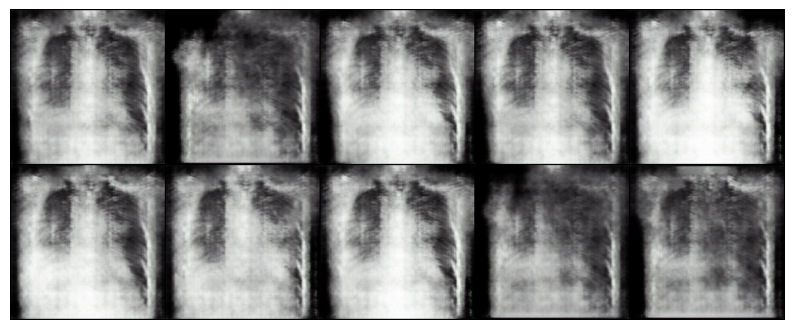

[Epoch 21/50] [Batch 137/138] [D loss: 0.01814110204577446] [G loss: 3.995997667312622]
[Epoch 22/50] [Batch 137/138] [D loss: 0.07392756640911102] [G loss: 6.082218170166016]
[Epoch 23/50] [Batch 137/138] [D loss: 0.888612687587738] [G loss: 6.810716152191162]
[Epoch 24/50] [Batch 137/138] [D loss: 0.19056445360183716] [G loss: 2.0658416748046875]
[Epoch 25/50] [Batch 137/138] [D loss: 0.024410009384155273] [G loss: 3.655231475830078]
[Epoch 26/50] [Batch 137/138] [D loss: 1.3768929243087769] [G loss: 4.768835544586182]
[Epoch 27/50] [Batch 137/138] [D loss: 0.08937611430883408] [G loss: 4.426357269287109]
[Epoch 28/50] [Batch 137/138] [D loss: 0.10797308385372162] [G loss: 2.155898332595825]
[Epoch 29/50] [Batch 137/138] [D loss: 0.11614330857992172] [G loss: 2.3342862129211426]
[Epoch 30/50] [Batch 137/138] [D loss: 4.960463047027588] [G loss: 17.443004608154297]


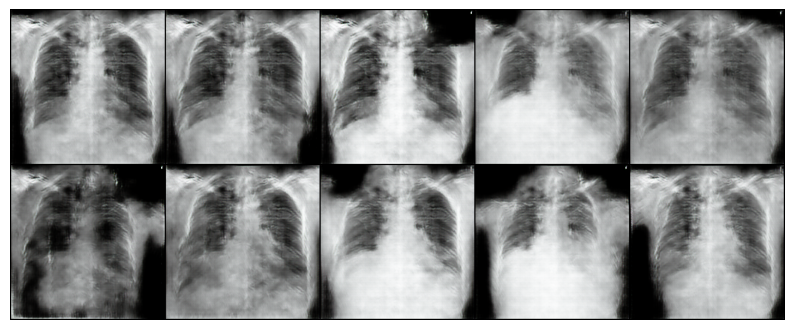

[Epoch 31/50] [Batch 137/138] [D loss: 0.01481280755251646] [G loss: 4.213714122772217]
[Epoch 32/50] [Batch 137/138] [D loss: 0.006369881797581911] [G loss: 5.1722025871276855]
[Epoch 33/50] [Batch 137/138] [D loss: 0.2748018503189087] [G loss: 1.3204660415649414]
[Epoch 34/50] [Batch 137/138] [D loss: 0.08330538868904114] [G loss: 3.972883701324463]
[Epoch 35/50] [Batch 137/138] [D loss: 0.06647388637065887] [G loss: 4.403059482574463]
[Epoch 36/50] [Batch 137/138] [D loss: 0.19852405786514282] [G loss: 2.9923741817474365]
[Epoch 37/50] [Batch 137/138] [D loss: 0.07851026952266693] [G loss: 5.247134685516357]
[Epoch 38/50] [Batch 137/138] [D loss: 4.8178189899772406e-05] [G loss: 11.68514633178711]
[Epoch 39/50] [Batch 137/138] [D loss: 0.031809329986572266] [G loss: 9.461543083190918]
[Epoch 40/50] [Batch 137/138] [D loss: 0.08694256097078323] [G loss: 4.415475845336914]


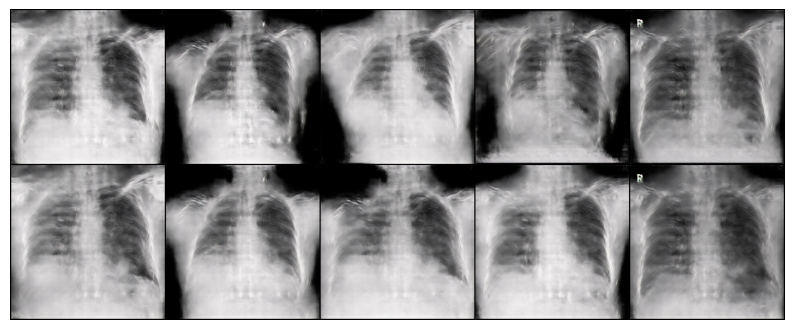

[Epoch 41/50] [Batch 137/138] [D loss: 0.5429161190986633] [G loss: 1.941355586051941]
[Epoch 42/50] [Batch 137/138] [D loss: 0.003339949296787381] [G loss: 8.790484428405762]
[Epoch 43/50] [Batch 137/138] [D loss: 0.010609230026602745] [G loss: 6.216475486755371]
[Epoch 44/50] [Batch 137/138] [D loss: 0.0935729593038559] [G loss: 4.692979335784912]
[Epoch 45/50] [Batch 137/138] [D loss: 0.001669410732574761] [G loss: 11.115842819213867]
[Epoch 46/50] [Batch 137/138] [D loss: 0.027555476874113083] [G loss: 11.737373352050781]
[Epoch 47/50] [Batch 137/138] [D loss: 0.014074018225073814] [G loss: 7.256478786468506]
[Epoch 48/50] [Batch 137/138] [D loss: 0.06468652933835983] [G loss: 3.4866435527801514]
[Epoch 49/50] [Batch 137/138] [D loss: 0.030667852610349655] [G loss: 4.331977844238281]


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from PIL import Image
import os

# Function to display and save generated images
def show_and_save_generated(imgs, labels, epoch, generated_images_dir, num_images=10):
    imgs = (imgs + 1) / 2  # Rescale images from [-1,1] to [0,1]
    grid = make_grid(imgs[:num_images], nrow=5).detach().cpu().numpy()
    grid = np.transpose(grid, (1, 2, 0))  # Convert from (C, H, W) to (H, W, C)

    # Display the grid of images
    plt.figure(figsize=(10, 5))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

    # Save individual images
    for i, img in enumerate(imgs):
        class_label = 'Diseased' if labels[i].item() == 0 else 'No_Disease'
        class_dir = os.path.join(generated_images_dir, class_label)
        os.makedirs(class_dir, exist_ok=True)  # Create the class directory if it doesn't exist
        image_path = os.path.join(class_dir, f'epoch_{epoch}_image_{i}.png')
        save_image(img, image_path)

# Define a directory to save model checkpoints
checkpoint_dir = '/kaggle/working/checkpoints_cgans/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define a directory to save generated images
generated_images_dir = '/kaggle/working/generated_images_cgans/'
os.makedirs(generated_images_dir, exist_ok=True)



epoch_losses = {}
# Training Loop
for epoch in range(epochs):
    
    epoch_g_loss = 0.0  # Initialize epoch generator loss
    epoch_d_loss = 0.0  # Initialize epoch discriminator loss
    for i, (imgs, labels) in enumerate(dataloader):
        
        valid = torch.ones(imgs.size(0), 1, requires_grad=False).to(device)
        fake = torch.zeros(imgs.size(0), 1, requires_grad=False).to(device)
        
        # Configure input
        real_imgs = imgs.to(device)
        labels = labels.to(device)
        
        # -----------------
        #  Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Sample noise and labels as generator input
        z = torch.randn(imgs.size(0), z_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)

        # Generate a batch of images
        gen_imgs = generator(z, gen_labels)

        # Loss measures generator's ability to fool the discriminator
        validity = discriminator(gen_imgs, gen_labels)
        g_loss = adversarial_loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = adversarial_loss(validity_real, valid)

        # Loss for fake images
        validity_fake = discriminator(gen_imgs.detach(), gen_labels)
        d_fake_loss = adversarial_loss(validity_fake, fake)

        # Total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        epoch_g_loss += g_loss.item()
        epoch_d_loss += d_loss.item()
    
    # Calculate average losses for this epoch
    avg_g_loss = epoch_g_loss / len(dataloader)
    avg_d_loss = epoch_d_loss / len(dataloader)
    
    epoch_losses[epoch] = {'generator_loss': avg_g_loss, 'discriminator_loss': avg_d_loss}
        
    print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

    # Save model checkpoints every 10 epochs and display grid of images
    if epoch % 10 == 0:
        torch.save(generator.state_dict(), os.path.join(checkpoint_dir, f'generator_epoch_{epoch}.pth'))
        torch.save(discriminator.state_dict(), os.path.join(checkpoint_dir, f'discriminator_epoch_{epoch}.pth'))

        # Generate and save example images
        with torch.no_grad():
            z_example = torch.randn(10, z_dim).to(device)  # Generate 10 random noise vectors
            gen_labels_example = torch.randint(0, n_classes, (10,)).to(device)  # Generate random labels
            gen_imgs_example = generator(z_example, gen_labels_example)
            show_and_save_generated(gen_imgs_example, gen_labels_example, epoch, generated_images_dir, num_images=10)


In [10]:
import plotly.graph_objects as go

# Extract generator and discriminator losses
generator_losses = [epoch_losses[epoch]['generator_loss'] for epoch in range(epochs)]
discriminator_losses = [epoch_losses[epoch]['discriminator_loss'] for epoch in range(epochs)]

# Create Plotly figure
fig = go.Figure()

# Add generator loss trace
fig.add_trace(go.Scatter(x=list(range(epochs)), y=generator_losses, mode='lines', name='Generator Loss'))

# Add discriminator loss trace
fig.add_trace(go.Scatter(x=list(range(epochs)), y=discriminator_losses, mode='lines', name='Discriminator Loss'))

# Update layout
fig.update_layout(title='Generator and Discriminator Losses vs Epoch',
                  xaxis_title='Epoch',
                  yaxis_title='Loss')

# Show plot
fig.show()
